<a href="https://colab.research.google.com/github/mkbahk/QuantumComputing/blob/main/Quantum_Linear_Equation_Solver_with_Qiskit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%pip install qiskit[visualization]
%pip install pylatexenc
%pip install qiskit-aer
%pip install matplotlib
%pip install numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 9.1 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=c5ecf51900a8dff609de1b41f235bdd9e3261eca2c059e67c0b12906beec4e1b
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 84.0 MB/s eta 0:00:00


In [15]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.quantum_info import Operator, Statevector
from qiskit.circuit.library import QFT
import matplotlib.pyplot as plt

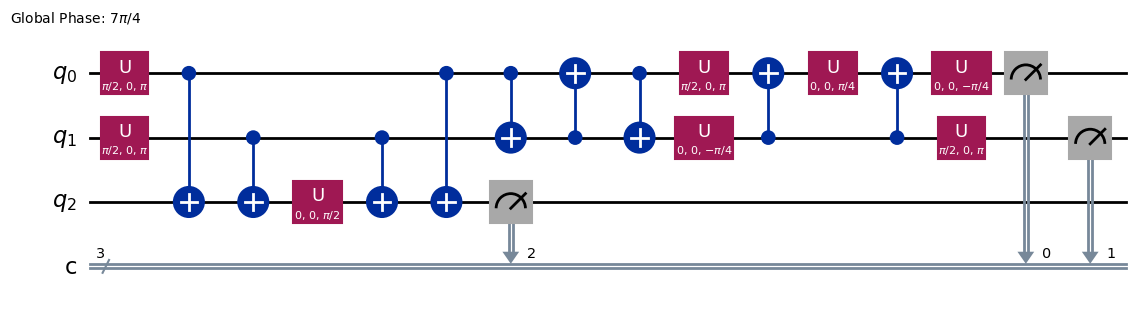

In [72]:
# 큐비트 레지스터 생성
qr = QuantumRegister(3, 'q')  # 2개는 해를 위한 큐비트, 1개는 보조 큐비트
cr = ClassicalRegister(3, 'c')
circuit = QuantumCircuit(qr, cr)

# 초기 상태 준비
circuit.h(qr[0])  # 첫 번째 큐비트에 Hadamard 게이트 적용
circuit.h(qr[1])  # 두 번째 큐비트에 Hadamard 게이트 적용

# 행렬 A 구현
# A = [[2, 1],
#      [1, 2]]
circuit.cx(qr[0], qr[2])
circuit.cx(qr[1], qr[2])
circuit.rz(np.pi/2, qr[2])
circuit.cx(qr[1], qr[2])
circuit.cx(qr[0], qr[2])

# 역양자 푸리에 변환 적용
# circuit.append(QFT(2).inverse(), [qr[0], qr[1]]) # Original line causing the error
# Instead of directly appending QFT.inverse(), decompose it first:
iqft_gate = QFT(2).inverse().to_gate()  # Create an IQFT gate
circuit.append(iqft_gate, [qr[0], qr[1]]) # Append the decomposed IQFT gate

# Decompose the IQFT gate into basic gates:
circuit = circuit.decompose(reps=10)
# 측정
circuit.measure(qr, cr)
circuit.draw(output='mpl')

In [73]:
def create_matrix_circuit():
    """두 개의 선형 연립방정식을 풀기 위한 양자 회로 생성"""
    # 예제 방정식:
    # 2x + y = 3
    # x + 2y = 4

    # 큐비트 레지스터 생성
    qr = QuantumRegister(3, 'q')  # 2개는 해를 위한 큐비트, 1개는 보조 큐비트
    cr = ClassicalRegister(3, 'c')
    circuit = QuantumCircuit(qr, cr)

    # 초기 상태 준비
    circuit.h(qr[0])  # 첫 번째 큐비트에 Hadamard 게이트 적용
    circuit.h(qr[1])  # 두 번째 큐비트에 Hadamard 게이트 적용

    # 행렬 A 구현
    # A = [[2, 1],
    #      [1, 2]]
    circuit.cx(qr[0], qr[2])
    circuit.cx(qr[1], qr[2])
    circuit.rz(np.pi/2, qr[2])
    circuit.cx(qr[1], qr[2])
    circuit.cx(qr[0], qr[2])

    # 역양자 푸리에 변환 적용
    # circuit.append(QFT(2).inverse(), [qr[0], qr[1]]) # Original line causing the error
    # Instead of directly appending QFT.inverse(), decompose it first:
    iqft_gate = QFT(2).inverse().to_gate()  # Create an IQFT gate
    circuit.append(iqft_gate, [qr[0], qr[1]]) # Append the decomposed IQFT gate

    # Decompose the IQFT gate into basic gates:
    circuit = circuit.decompose(reps=10)

    # 측정
    circuit.measure(qr, cr)

    return circuit

In [74]:
def solve_equations():
    """방정식 풀이 및 결과 출력"""
    # 회로 생성
    circuit = create_matrix_circuit()

    # 시뮬레이터 설정
    backend = Aer.get_backend('unitary_simulator')

    # 회로 실행
    job = backend.run(circuit, shots=1000)
    result = job.result()

    # 결과 얻기
    counts = result.get_counts(circuit)

    # 결과 분석 및 시각화
    plot_results(counts)

    return counts


In [75]:
def plot_results(counts):
    """결과 시각화"""
    plt.figure(figsize=(10, 6))
    plt.bar(counts.keys(), counts.values())
    plt.title('양자 회로 측정 결과')
    plt.xlabel('측정된 상태')
    plt.ylabel('발생 횟수')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 고전적 해법과 비교
    A = np.array([[2, 1],
                  [1, 2]])
    b = np.array([3, 4])
    classical_solution = np.linalg.solve(A, b)
    print("\n고전적 해법 결과:")
    print(f"x = {classical_solution[0]:.4f}")
    print(f"y = {classical_solution[1]:.4f}")


In [76]:
if __name__ == "__main__":
    print("선형 연립방정식 풀이 시작...")
    print("방정식 시스템:")
    print("2x + y = 3")
    print("x + 2y = 4")

    results = solve_equations()

    print("\n양자 회로 측정 결과:")
    for state, count in results.items():
        print(f"상태 {state}: {count} 회 측정됨")

ERROR:  [Experiment 0] Circuit circuit-454 contains invalid instructions {"instructions": {save_unitary}} for "statevector" method.Circuit circuit-454 contains invalid parameters  for "statevector" method.


선형 연립방정식 풀이 시작...
방정식 시스템:
2x + y = 3
x + 2y = 4


QiskitError: 'Data for experiment "circuit-454" could not be found.'